# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [64]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [66]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [67]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [68]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [69]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for param_0
Gradient check passed!
Checking gradient for param_1
Gradient check passed!
Checking gradient for param_2
Gradient check passed!
Checking gradient for param_3
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [70]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for param_0
Gradient check passed!
Checking gradient for param_1
Gradient check passed!
Checking gradient for param_2
Gradient check passed!
Checking gradient for param_3
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [71]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [77]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
train_loss_history, val_loss_history, train_acc_history, val_acc_history = trainer.fit()

Train loss: 2.321320, val loss: 5.384866, train accuracy: 0.196667, val accuracy: 0.072000
Train loss: 2.302298, val loss: 2.302183, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302295, val loss: 2.302383, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302292, val loss: 2.302121, train accuracy: 0.148222, val accuracy: 0.206000
Train loss: 2.302314, val loss: 2.302323, train accuracy: 0.196667, val accuracy: 0.140000
Train loss: 2.302286, val loss: 2.302088, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302293, val loss: 2.302119, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302285, val loss: 2.302158, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302312, val loss: 2.302229, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302288, val loss: 2.302141, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302296, val loss: 2.302215, train accuracy: 0.196667, val accuracy: 0.206000

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [78]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
train_loss_history, val_loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Train loss: 2.299020, val loss: 2.333414, train accuracy: 0.196667, val accuracy: 0.062000
Train loss: 2.278365, val loss: 2.277364, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.275763, val loss: 2.270304, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.275210, val loss: 2.268788, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.274683, val loss: 2.268628, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.273854, val loss: 2.267405, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.273001, val loss: 2.266649, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.272223, val loss: 2.265039, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.271841, val loss: 2.264050, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.271710, val loss: 2.263508, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.271645, val loss: 2.263441, train accuracy: 0.196667, val accuracy: 0.206000

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [80]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
train_loss_history, val_loss_history, train_history, val_history = trainer.fit()

Train loss: 2.327435, val loss: 2.333237, train accuracy: 0.196667, val accuracy: 0.138000
Train loss: 2.317041, val loss: 2.321009, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.308849, val loss: 2.311122, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.302374, val loss: 2.303326, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.297241, val loss: 2.297045, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.293151, val loss: 2.292032, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.289873, val loss: 2.288030, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.287247, val loss: 2.284769, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.285132, val loss: 2.282104, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.283414, val loss: 2.279969, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.282022, val loss: 2.278206, train accuracy: 0.196667, val accuracy: 0.206000

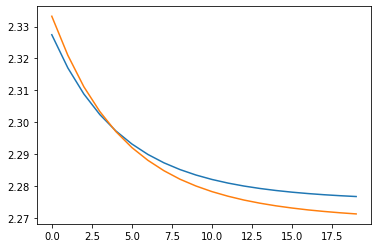

In [83]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [84]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
train_loss_history, val_loss_history, train_history, val_history = trainer.fit()

Train loss: 2.337005, val loss: 2.333410, train accuracy: 0.266667, val accuracy: 0.066667
Train loss: 2.320738, val loss: 2.328338, train accuracy: 0.200000, val accuracy: 0.066667
Train loss: 2.307938, val loss: 2.324709, train accuracy: 0.200000, val accuracy: 0.133333
Train loss: 2.300504, val loss: 2.322373, train accuracy: 0.200000, val accuracy: 0.133333
Train loss: 2.291078, val loss: 2.321321, train accuracy: 0.266667, val accuracy: 0.133333
Train loss: 2.279760, val loss: 2.321587, train accuracy: 0.266667, val accuracy: 0.000000
Train loss: 2.268128, val loss: 2.324176, train accuracy: 0.266667, val accuracy: 0.000000
Train loss: 2.250930, val loss: 2.331084, train accuracy: 0.266667, val accuracy: 0.000000
Train loss: 2.210024, val loss: 2.346865, train accuracy: 0.266667, val accuracy: 0.000000
Train loss: 2.162179, val loss: 2.387068, train accuracy: 0.400000, val accuracy: 0.000000
Train loss: 2.083014, val loss: 2.455162, train accuracy: 0.400000, val accuracy: 0.000000

Train loss: 1.331583, val loss: 3.886306, train accuracy: 0.933333, val accuracy: 0.066667
Train loss: 1.330659, val loss: 3.908388, train accuracy: 0.933333, val accuracy: 0.066667
Train loss: 1.315977, val loss: 3.835686, train accuracy: 0.933333, val accuracy: 0.066667
Train loss: 1.299280, val loss: 3.845620, train accuracy: 1.000000, val accuracy: 0.066667
Train loss: 1.304794, val loss: 3.889761, train accuracy: 1.000000, val accuracy: 0.066667
Train loss: 1.313110, val loss: 3.928366, train accuracy: 0.933333, val accuracy: 0.066667
Train loss: 1.302526, val loss: 3.886014, train accuracy: 1.000000, val accuracy: 0.066667
Train loss: 1.290926, val loss: 3.947218, train accuracy: 1.000000, val accuracy: 0.066667
Train loss: 1.301515, val loss: 3.990347, train accuracy: 1.000000, val accuracy: 0.066667
Train loss: 1.291278, val loss: 3.908122, train accuracy: 1.000000, val accuracy: 0.066667
Train loss: 1.296393, val loss: 3.935784, train accuracy: 1.000000, val accuracy: 0.066667

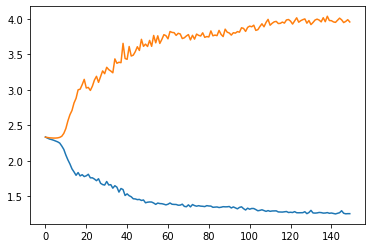

In [85]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [88]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less


dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])

#model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
#trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.01)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.99,
                  num_epochs=20, batch_size=5)

train_loss_history, val_loss_history, train_history, val_history = trainer.fit()

Train loss: 2.311835, val loss: 2.305627, train accuracy: 0.200000, val accuracy: 0.133333
Train loss: 2.275169, val loss: 2.299711, train accuracy: 0.200000, val accuracy: 0.066667
Train loss: 2.228475, val loss: 2.294051, train accuracy: 0.200000, val accuracy: 0.133333
Train loss: 2.184538, val loss: 2.308246, train accuracy: 0.266667, val accuracy: 0.133333
Train loss: 1.997378, val loss: 2.401904, train accuracy: 0.400000, val accuracy: 0.000000
Train loss: 1.871719, val loss: 3.080008, train accuracy: 0.466667, val accuracy: 0.000000
Train loss: 1.641050, val loss: 3.534438, train accuracy: 0.400000, val accuracy: 0.000000
Train loss: 1.518906, val loss: 3.819001, train accuracy: 0.466667, val accuracy: 0.133333
Train loss: 1.315534, val loss: 4.189881, train accuracy: 0.600000, val accuracy: 0.000000
Train loss: 1.363558, val loss: 4.735193, train accuracy: 0.666667, val accuracy: 0.000000
Train loss: 1.545160, val loss: 4.838770, train accuracy: 0.666667, val accuracy: 0.000000

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [98]:
dataset = Dataset(train_X, train_y, val_X, val_y)

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.01)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.99,
                  num_epochs=200, batch_size=300)

train_loss_history, val_loss_history, train_history, val_history = trainer.fit()

Train loss: 2.258463, val loss: 2.305782, train accuracy: 0.196667, val accuracy: 0.078000
Train loss: 2.238913, val loss: 2.222168, train accuracy: 0.196667, val accuracy: 0.206000
Train loss: 2.196422, val loss: 2.217258, train accuracy: 0.237778, val accuracy: 0.206000
Train loss: 2.125807, val loss: 2.125935, train accuracy: 0.269778, val accuracy: 0.241000
Train loss: 2.051063, val loss: 2.088219, train accuracy: 0.347000, val accuracy: 0.279000
Train loss: 1.978509, val loss: 1.991337, train accuracy: 0.399889, val accuracy: 0.358000
Train loss: 1.934723, val loss: 1.933762, train accuracy: 0.456889, val accuracy: 0.381000
Train loss: 1.888261, val loss: 1.876160, train accuracy: 0.499556, val accuracy: 0.480000
Train loss: 1.842334, val loss: 1.859551, train accuracy: 0.551333, val accuracy: 0.518000
Train loss: 1.826174, val loss: 1.835439, train accuracy: 0.576556, val accuracy: 0.563000
Train loss: 1.809299, val loss: 1.805525, train accuracy: 0.556444, val accuracy: 0.566000

Train loss: 1.733546, val loss: 1.734475, train accuracy: 0.669000, val accuracy: 0.679000
Train loss: 1.734440, val loss: 1.733693, train accuracy: 0.676333, val accuracy: 0.655000
Train loss: 1.740083, val loss: 1.742929, train accuracy: 0.685111, val accuracy: 0.667000
Train loss: 1.736767, val loss: 1.781415, train accuracy: 0.671778, val accuracy: 0.664000
Train loss: 1.737291, val loss: 1.751143, train accuracy: 0.673889, val accuracy: 0.667000
Train loss: 1.738603, val loss: 1.757532, train accuracy: 0.670444, val accuracy: 0.647000
Train loss: 1.737429, val loss: 1.780069, train accuracy: 0.687667, val accuracy: 0.647000
Train loss: 1.739356, val loss: 1.764350, train accuracy: 0.676889, val accuracy: 0.663000
Train loss: 1.738813, val loss: 1.768837, train accuracy: 0.682667, val accuracy: 0.651000
Train loss: 1.736792, val loss: 1.736189, train accuracy: 0.675778, val accuracy: 0.665000
Train loss: 1.735520, val loss: 1.742458, train accuracy: 0.683778, val accuracy: 0.660000

Train loss: 1.715553, val loss: 1.715890, train accuracy: 0.691333, val accuracy: 0.674000
Train loss: 1.716281, val loss: 1.718714, train accuracy: 0.685778, val accuracy: 0.677000
Train loss: 1.716979, val loss: 1.746553, train accuracy: 0.692000, val accuracy: 0.672000
Train loss: 1.715147, val loss: 1.732524, train accuracy: 0.696556, val accuracy: 0.679000
Train loss: 1.716709, val loss: 1.736079, train accuracy: 0.691556, val accuracy: 0.683000
Train loss: 1.715924, val loss: 1.752914, train accuracy: 0.695222, val accuracy: 0.677000
Train loss: 1.716043, val loss: 1.752117, train accuracy: 0.698111, val accuracy: 0.678000
Train loss: 1.714629, val loss: 1.738065, train accuracy: 0.695333, val accuracy: 0.673000
Train loss: 1.716055, val loss: 1.747298, train accuracy: 0.696778, val accuracy: 0.671000
Train loss: 1.714115, val loss: 1.736447, train accuracy: 0.693111, val accuracy: 0.681000
Train loss: 1.715124, val loss: 1.749113, train accuracy: 0.694778, val accuracy: 0.673000

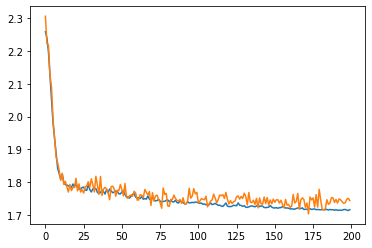

In [99]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

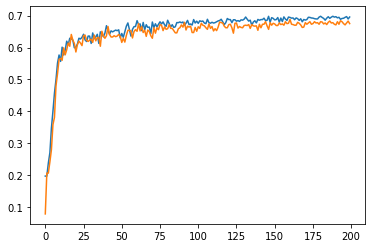

In [100]:
plt.plot(train_history)
plt.plot(val_history)

In [101]:
best_classifier = model
best_val_accuracy = val_history[-1]

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [102]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.649000
